Original Acc: 0.43
PCA Acc: 0.27
LDA Acc: 0.37


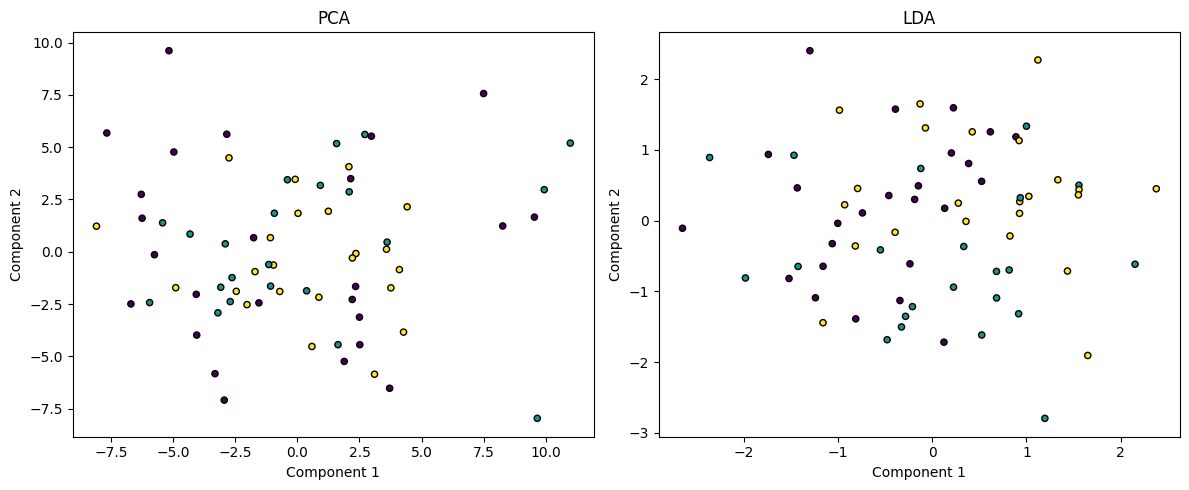

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 生成高维数据集
X, y = make_classification(n_samples=100, n_features=500, n_informative=3, n_classes=3, random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PCA 降维到 2 维
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# LDA 降维到 2 维
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# 使用 KNN 分类器评估降维后的性能
knn = KNeighborsClassifier(n_neighbors=5)

# 原始数据上的分类性能
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)

# PCA 降维后的分类性能
knn.fit(X_train_pca, y_train)
y_pred_pca = knn.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

# LDA 降维后的分类性能
knn.fit(X_train_lda, y_train)
y_pred_lda = knn.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

print(f'Original Acc: {accuracy_original:.2f}')
print(f'PCA Acc: {accuracy_pca:.2f}')
print(f'LDA Acc: {accuracy_lda:.2f}')

# 可视化降维结果
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=20)
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=20)
plt.title('LDA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import GEOparse

# 从 GEO 下载数据集
gse_id = 'GSE10072'  # 替换为您感兴趣的 GEO Series ID
gse = GEOparse.get_GEO(geo=gse_id, destdir="./")

# 提取表达矩阵和样本信息
samples = gse.gsms
data = []
labels = []
for gsm_name, gsm in samples.items():
    # 检查 GSM 的标题，提取 AML 和 ALL 样本
    title = gsm.metadata.get('title', [''])[0]
    if 'Tumor' in title:
        labels.append(1)
        data.append(gsm.table['VALUE'].values)
    elif 'Normal' in title:
        labels.append(0)
        data.append(gsm.table['VALUE'].values)

# 转换为 NumPy 数组
if len(data) == 0 or len(labels) == 0:
    raise ValueError("No samples were extracted. Please check the dataset and adjust the label extraction logic.")

X = np.array(data)
y = np.array(labels)

# 检查数据形状
print(f"Data shape: {X.shape}, label shape: {y.shape}")

# 检查是否有足够样本用于划分
if len(X) < 2:
    raise ValueError("Not enough samples to split into train and test sets.")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义模型列表
models = {
    "LDA": LDA(),
    "L1 Regularization (Lasso)": Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42))
    ]),
    "L2 Regularization (Ridge)": Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", LogisticRegression(penalty="l2", solver="saga", max_iter=1000, random_state=42))
    ]),
    "Supervised PCA": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", TruncatedSVD(n_components=10, random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000, random_state=42))
    ])
}

# 存储结果
results = []

# 训练和评估模型
for name, model in models.items():
    # 使用交叉验证计算训练集性能
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # 保存结果
    results.append({
        "Model": name,
        "CV Mean Accuracy": np.mean(cv_scores),
    })

# 转换为 DataFrame 展示
results_df = pd.DataFrame(results)
print(results_df)

19-Nov-2024 18:27:06 DEBUG utils - Directory ./ already exists. Skipping.
19-Nov-2024 18:27:06 INFO GEOparse - File already exist: using local version.
19-Nov-2024 18:27:06 INFO GEOparse - Parsing ./GSE10072_family.soft.gz: 
19-Nov-2024 18:27:06 DEBUG GEOparse - DATABASE: GeoMiame
19-Nov-2024 18:27:06 DEBUG GEOparse - SERIES: GSE10072
19-Nov-2024 18:27:06 DEBUG GEOparse - PLATFORM: GPL96
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254625
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254626
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254627
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254628
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254629
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254630
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254631
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254632
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254633
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM254634
19-Nov-2024 18:27:08 DEBUG GEOparse - SAMPLE: GSM

Data shape: (107, 22283), label shape: (107,)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

                       Model  CV Mean Accuracy
0                        LDA          0.960000
1  L1 Regularization (Lasso)          1.000000
2  L2 Regularization (Ridge)          0.986667
3             Supervised PCA          0.959048
